In [1]:
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textwrap

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from utils import pca, preprocess_data, plot_bar_importance, plot_confusion_matrix

In [2]:
path = "./gss_16.rda"

In [3]:
data = pyreadr.read_r(path)

In [4]:
df = data["gss16"]

# Phân loại tập dữ liệu thời gian sử dụng email khác null sử dụng Multinomial Logistic Regression

### Xử lý dữ liệu và thực hiện phân tích thành phần chính

In [5]:
x, y, features_list, value_to_index = preprocess_data(df=df, remove_email_null=True, use_text_categorical=False, one_hot_encode=True)

U, reduced_x = pca(x=x, alpha=0.5)

reduced_x, x.shape

(array([[ 0.76516265, -1.16874744, -0.15042556,  0.18296905],
        [ 0.0738515 ,  0.73155778,  1.01875332,  0.28174455],
        [ 1.41275401, -0.15268227, -0.10413859, -0.70098884],
        ...,
        [ 1.26932849, -0.34444335, -0.12803762,  0.26231042],
        [ 0.61683124,  0.36932971, -1.26404303, -0.81219695],
        [ 1.47759915, -0.40272091,  0.23605025, -0.18099993]]),
 (1648, 46))

## Sử dụng feature thu được từ PCA

### Phân chia tập dữ liệu

In [6]:
X_train, X_test, y_train, y_test = train_test_split(reduced_x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình Logistic

In [7]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='saga')

### Kết quả huấn luyện mô hình

In [8]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        58
           Other       0.00      0.00      0.00         8
         Retired       0.00      0.00      0.00       109
          School       0.00      0.00      0.00        14
Temp not working       0.00      0.00      0.00        15
Unempl, laid off       0.00      0.00      0.00        25
Working fulltime       0.53      1.00      0.69       351
Working parttime       0.00      0.00      0.00        80

        accuracy                           0.53       660
       macro avg       0.07      0.12      0.09       660
    weighted avg       0.28      0.53      0.37       660



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Ma trận nhầm lẫn cho tập test

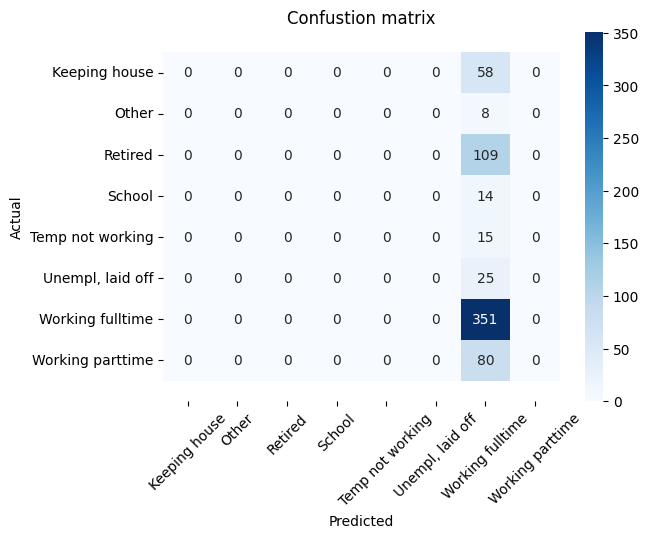

In [9]:
classes = model.classes_
plot_confusion_matrix(y_test, y_pred, classes=classes)

### List là danh sách các đặc trưng được đưa vào mô hình

In [10]:
index_to_features_list = dict(zip(range(len(features_list)), features_list))

index_to_features_list

{0: 'emailtotal',
 1: 'harass5_0',
 2: 'harass5_1',
 3: 'harass5_2',
 4: 'harass5_3',
 5: 'snapchat_0',
 6: 'snapchat_1',
 7: 'snapchat_2',
 8: 'instagrm_0',
 9: 'instagrm_1',
 10: 'instagrm_2',
 11: 'polviews_0',
 12: 'polviews_1',
 13: 'polviews_2',
 14: 'polviews_3',
 15: 'polviews_4',
 16: 'polviews_5',
 17: 'polviews_6',
 18: 'polviews_7',
 19: 'advfront_0',
 20: 'advfront_1',
 21: 'advfront_2',
 22: 'advfront_3',
 23: 'advfront_4',
 24: 'advfront_5',
 25: 'educ_0',
 26: 'educ_1',
 27: 'educ_2',
 28: 'educ_3',
 29: 'educ_4',
 30: 'educ_5',
 31: 'educ_6',
 32: 'educ_7',
 33: 'educ_8',
 34: 'educ_9',
 35: 'educ_10',
 36: 'educ_11',
 37: 'educ_12',
 38: 'educ_13',
 39: 'educ_14',
 40: 'educ_15',
 41: 'educ_16',
 42: 'educ_17',
 43: 'educ_18',
 44: 'educ_19',
 45: 'educ_20'}

### Từ điển biến chỉ số thành tên đặc trưng dễ đọc hơn

In [11]:
index_to_features_list_update = {}
for k, v in index_to_features_list.items():
    if v == "emailtotal":
        index_to_features_list_update[k] = v
    else:
        field, index = v.split("_")
        val_to_ind = {v: k for k, v in value_to_index[field].items()}
        #print(val_to_ind)
        if int(index) in val_to_ind:
            text_value = val_to_ind[int(index)]
            if isinstance(text_value, str):
                space_split = text_value.split(" ")
                if len(space_split) == 1:
                    index_to_features_list_update[k] = "{}_{}".format(field, space_split[0])
                else:
                    index_to_features_list_update[k] = "{}_{}".format(field, "_".join(space_split))
            else:
                index_to_features_list_update[k] = "{}_{}".format(field, int(text_value))
        else:
            index_to_features_list_update[k] = "{}_{}".format(field, "Unknown")
index_to_features_list = index_to_features_list_update
index_to_features_list

{0: 'emailtotal',
 1: 'harass5_Unknown',
 2: 'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
 3: 'harass5_No',
 4: 'harass5_Yes',
 5: 'snapchat_Unknown',
 6: 'snapchat_No',
 7: 'snapchat_Yes',
 8: 'instagrm_Unknown',
 9: 'instagrm_No',
 10: 'instagrm_Yes',
 11: 'polviews_Unknown',
 12: 'polviews_Extrmly_conservative',
 13: 'polviews_Conservative',
 14: 'polviews_Slghtly_conservative',
 15: 'polviews_Moderate',
 16: 'polviews_Slightly_liberal',
 17: 'polviews_Liberal',
 18: 'polviews_Extremely_liberal',
 19: 'advfront_Unknown',
 20: 'advfront_Strongly_disagree',
 21: 'advfront_Disagree',
 22: 'advfront_Dont_know',
 23: 'advfront_Agree',
 24: 'advfront_Strongly_agree',
 25: 'educ_0',
 26: 'educ_1',
 27: 'educ_2',
 28: 'educ_3',
 29: 'educ_4',
 30: 'educ_5',
 31: 'educ_6',
 32: 'educ_7',
 33: 'educ_8',
 34: 'educ_9',
 35: 'educ_10',
 36: 'educ_11',
 37: 'educ_12',
 38: 'educ_13',
 39: 'educ_14',
 40: 'educ_15',
 41: 'educ_16',
 42: 'educ_17',
 43: 'educ_18',
 44: 'educ_

### Tên các nhãn từ tập dữ liệu

In [12]:
# pseudo_label = np.unique(y)
# index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
# index_to_pseudo_label

pseudo_label = model.classes_
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: 'Keeping house',
 1: 'Other',
 2: 'Retired',
 3: 'School',
 4: 'Temp not working',
 5: 'Unempl, laid off',
 6: 'Working fulltime',
 7: 'Working parttime'}

### Biến đổi weights của mô hình PCA thành weight của các đặc trưng ban đầu

In [13]:
original_weights = model.coef_.dot(U.T)

### Lấy k feature có trị tuyệt đối của weight cao nhất

In [14]:
top_k_features = 10

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [15]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]], 3)))
    
importance

{'Keeping house': {'emailtotal': (-0.167+0j),
  'advfront_Agree': (0.135+0j),
  'snapchat_No': (0.105+0j),
  'instagrm_Unknown': (-0.102+0j),
  'snapchat_Unknown': (-0.102+0j),
  'instagrm_No': (0.09+0j),
  'harass5_Unknown': (0.082+0j),
  'advfront_Unknown': (-0.081+0j),
  'harass5_No': (-0.07+0j),
  'polviews_Moderate': (0.06+0j)},
 'Other': {'emailtotal': (-1.2+0j),
  'educ_12': (0.167+0j),
  'polviews_Moderate': (0.145+0j),
  'advfront_Strongly_agree': (-0.14+0j),
  'educ_16': (-0.126+0j),
  'advfront_Agree': (0.097+0j),
  'instagrm_Unknown': (0.061+0j),
  'snapchat_Unknown': (0.061+0j),
  'snapchat_No': (-0.057+0j),
  'polviews_Liberal': (-0.052+0j)},
 'Retired': {'snapchat_Unknown': (0.172+0j),
  'instagrm_Unknown': (0.172+0j),
  'snapchat_No': (-0.168+0j),
  'emailtotal': (-0.155+0j),
  'instagrm_No': (-0.148+0j),
  'harass5_Unknown': (-0.05+0j),
  'advfront_Unknown': (0.049+0j),
  'harass5_No': (0.044+0j),
  'advfront_Agree': (-0.038+0j),
  'educ_12': (0.034+0j)},
 'School': {'

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to 

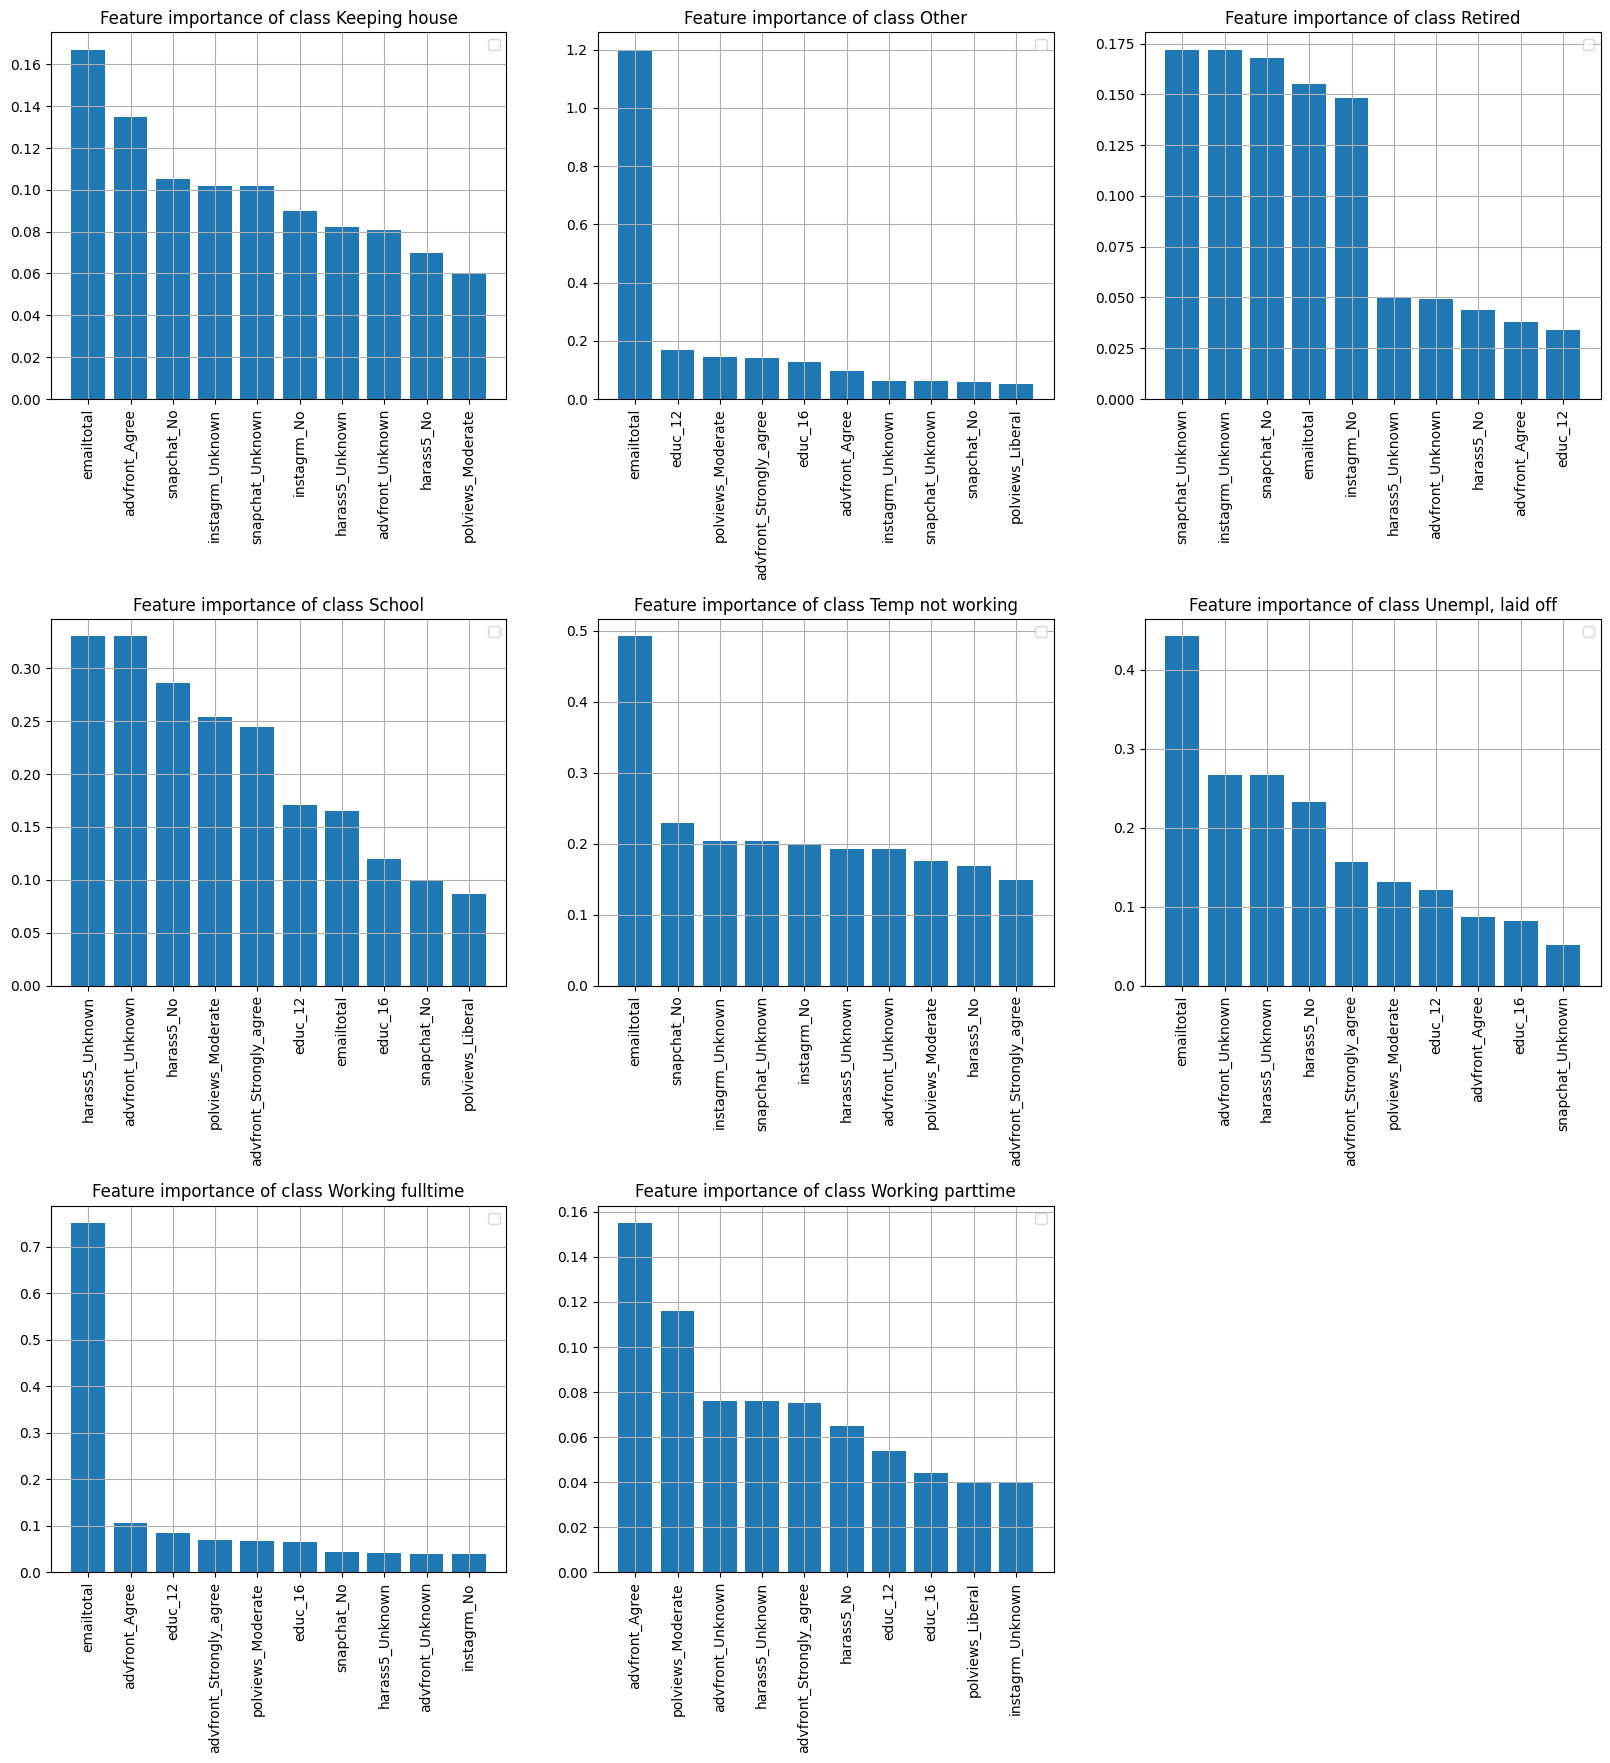

In [16]:
plot_bar_importance(importance)

### Barplot tương ứng với độ lớn bias tương ứng với từng lớp

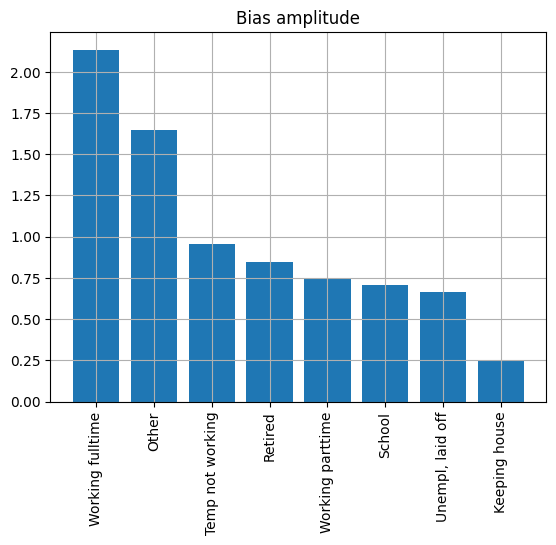

In [17]:
importance_intercept = dict(zip(np.vectorize(lambda x: index_to_pseudo_label[x])(np.argsort(np.abs(model.intercept_))[::-1]), np.round(model.intercept_[np.argsort(np.abs(model.intercept_))[::-1]], 3)))
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid()
plt.title("Bias amplitude")
plt.show()

## Sử dụng feature gốc

### Phân chia tập dữ liệu


In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình Logistic

In [19]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='saga')

### Kết quả huấn luyện mô hình

In [20]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.21      0.09      0.12        58
           Other       0.00      0.00      0.00         8
         Retired       0.36      0.14      0.20       109
          School       0.00      0.00      0.00        14
Temp not working       0.00      0.00      0.00        15
Unempl, laid off       0.00      0.00      0.00        25
Working fulltime       0.56      0.90      0.69       351
Working parttime       0.19      0.06      0.09        80

        accuracy                           0.52       660
       macro avg       0.16      0.15      0.14       660
    weighted avg       0.40      0.52      0.42       660



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Ma trận nhầm lẫn cho tập test

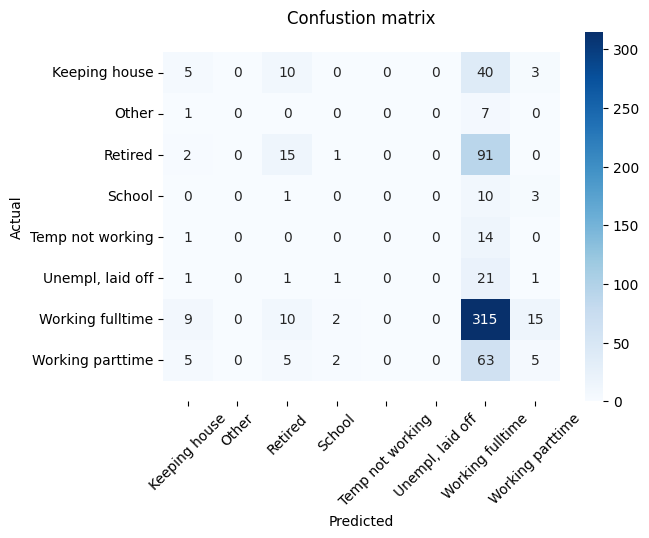

In [21]:
classes = model.classes_
plot_confusion_matrix(y_test, y_pred, classes=classes)

### weight tương ứng các đặc trưng ban đầu

In [22]:
original_weights = model.coef_

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [23]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]], 3)))
    
importance

{'Keeping house': {'advfront_Dont_know': 0.974,
  'polviews_Extrmly_conservative': 0.877,
  'educ_4': 0.827,
  'educ_19': -0.675,
  'educ_10': 0.608,
  'polviews_Unknown': 0.572,
  'advfront_Strongly_agree': -0.572,
  'educ_15': -0.56,
  'polviews_Conservative': -0.556,
  'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)': 0.503},
 'Other': {'emailtotal': -0.978,
  'polviews_Slightly_liberal': -0.822,
  'educ_9': 0.739,
  'educ_14': 0.683,
  'educ_11': 0.479,
  'educ_10': -0.466,
  'educ_16': -0.459,
  'advfront_Disagree': 0.45,
  'polviews_Extrmly_conservative': -0.446,
  'educ_17': -0.399},
 'Retired': {'snapchat_Yes': -1.055,
  'instagrm_Yes': -0.984,
  'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)': 0.84,
  'educ_17': 0.8,
  'educ_19': 0.798,
  'advfront_Strongly_disagree': 0.786,
  'harass5_Yes': -0.728,
  'educ_9': -0.685,
  'snapchat_Unknown': 0.684,
  'instagrm_Unknown': 0.684},
 'School': {'educ_15': 0.976,
  'harass5_Does_not_apply_(i_do_not_

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to 

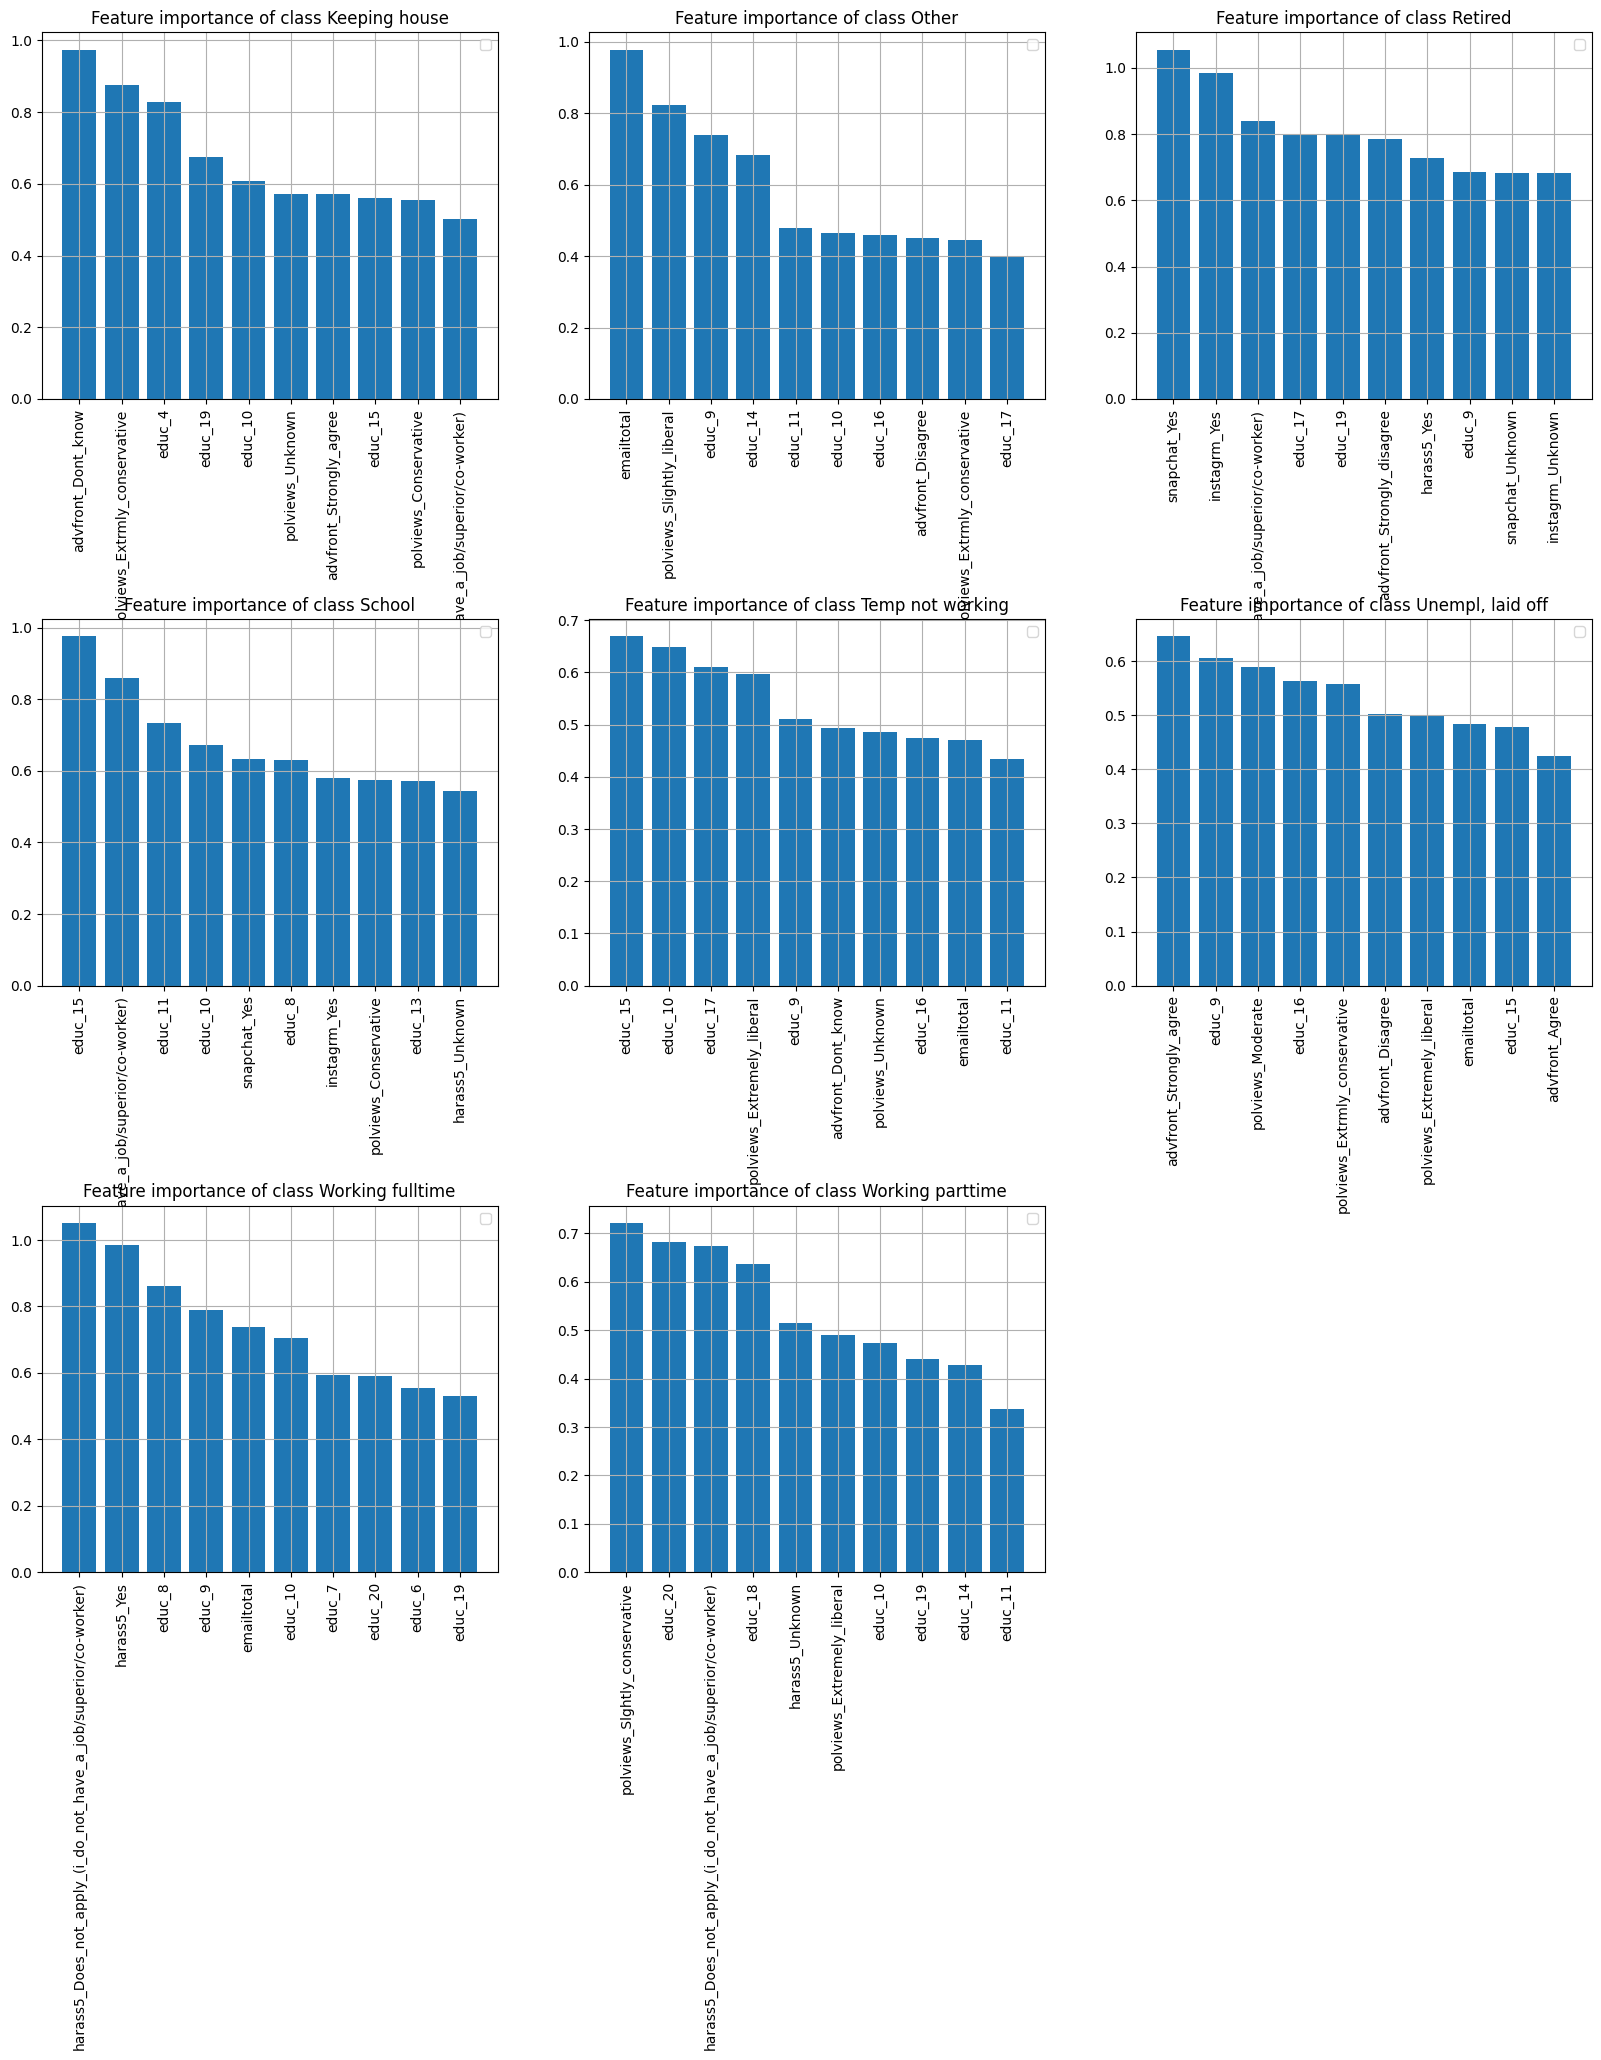

In [24]:
plot_bar_importance(importance)

### Barplot tương ứng với độ lớn bias tương ứng với từng lớp

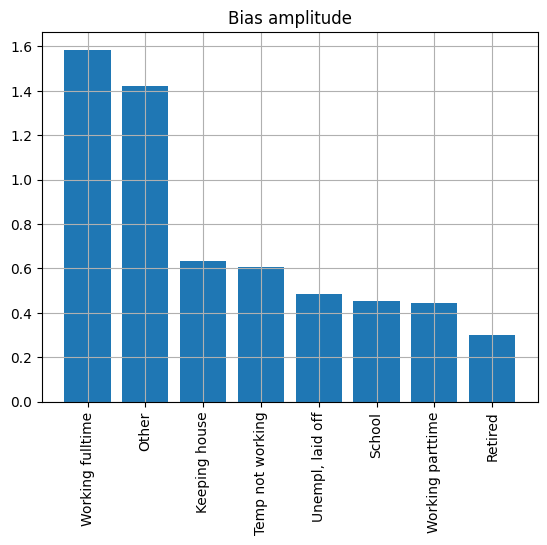

In [25]:
importance_intercept = dict(zip(np.vectorize(lambda x: index_to_pseudo_label[x])(np.argsort(np.abs(model.intercept_))[::-1]), np.round(model.intercept_[np.argsort(np.abs(model.intercept_))[::-1]], 3)))
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid()
plt.title("Bias amplitude")
plt.show()

# Phân loại tập dữ liệu với email là null sử dụng Multinomial Logistic Regression

## Sử dụng feature thu được từ PCA

### Phân tích PCA dữ liệu

In [26]:
x, y, features_list, value_to_index= preprocess_data(df=df, remove_email_null=False, use_text_categorical=False, one_hot_encode=True)

U, reduced_x = pca(x=x, alpha=0.4)

reduced_x, x.shape

(array([[ 1.30435   ,  0.46552921,  0.28922308],
        [ 0.60632419,  1.35262702, -0.48602664],
        [ 0.5626903 ,  1.33346182, -0.48373106],
        ...,
        [-0.64536006,  1.17042439,  0.69260063],
        [-0.68966536,  1.249954  ,  0.62442762],
        [ 1.3486553 ,  0.38599959,  0.35739608]]),
 (1210, 45))

### Phân chia tập dữ liệu

In [27]:
X_train, X_test, y_train, y_test = train_test_split(reduced_x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình Logistic

In [28]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='saga')

### Kết quả huấn luyện mô hình

In [29]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        55
           Other       0.00      0.00      0.00        23
         Retired       0.39      0.42      0.41       113
          School       0.00      0.00      0.00        13
Temp not working       0.00      0.00      0.00         8
Unempl, laid off       0.00      0.00      0.00        19
Working fulltime       0.48      0.87      0.62       198
Working parttime       0.00      0.00      0.00        55

        accuracy                           0.46       484
       macro avg       0.11      0.16      0.13       484
    weighted avg       0.29      0.46      0.35       484



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Ma trận nhầm lẫn cho tập test

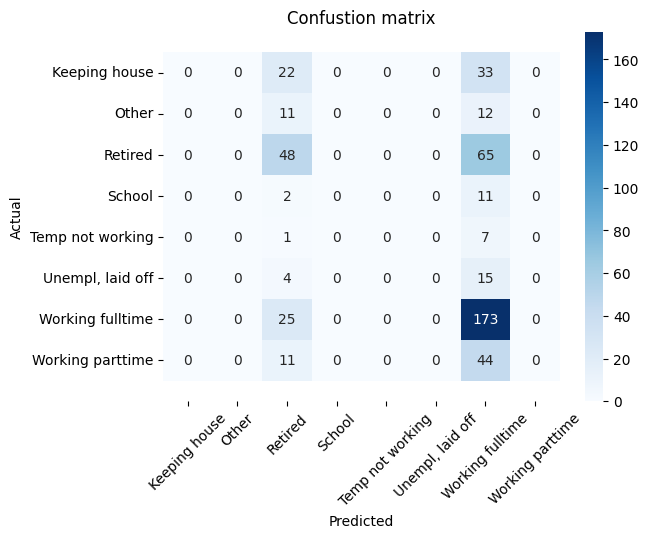

In [30]:
classes = model.classes_
plot_confusion_matrix(y_test, y_pred, classes=classes)

### List là danh sách các đặc trưng được đưa vào mô hình

In [31]:
index_to_features_list = dict(zip(range(len(features_list)), features_list))

index_to_features_list

{0: 'harass5_0',
 1: 'harass5_1',
 2: 'harass5_2',
 3: 'harass5_3',
 4: 'snapchat_0',
 5: 'snapchat_1',
 6: 'snapchat_2',
 7: 'instagrm_0',
 8: 'instagrm_1',
 9: 'instagrm_2',
 10: 'polviews_0',
 11: 'polviews_1',
 12: 'polviews_2',
 13: 'polviews_3',
 14: 'polviews_4',
 15: 'polviews_5',
 16: 'polviews_6',
 17: 'polviews_7',
 18: 'advfront_0',
 19: 'advfront_1',
 20: 'advfront_2',
 21: 'advfront_3',
 22: 'advfront_4',
 23: 'advfront_5',
 24: 'educ_0',
 25: 'educ_1',
 26: 'educ_2',
 27: 'educ_3',
 28: 'educ_4',
 29: 'educ_5',
 30: 'educ_6',
 31: 'educ_7',
 32: 'educ_8',
 33: 'educ_9',
 34: 'educ_10',
 35: 'educ_11',
 36: 'educ_12',
 37: 'educ_13',
 38: 'educ_14',
 39: 'educ_15',
 40: 'educ_16',
 41: 'educ_17',
 42: 'educ_18',
 43: 'educ_19',
 44: 'educ_20'}

### Từ điển biến chỉ số thành tên đặc trưng dễ đọc hơn

In [32]:
index_to_features_list_update = {}
for k, v in index_to_features_list.items():
    if v == "emailtotal":
        index_to_features_list_update[k] = v
    else:
        field, index = v.split("_")
        val_to_ind = {v: k for k, v in value_to_index[field].items()}
        #print(val_to_ind)
        if int(index) in val_to_ind:
            text_value = val_to_ind[int(index)]
            if isinstance(text_value, str):
                space_split = text_value.split(" ")
                if len(space_split) == 1:
                    index_to_features_list_update[k] = "{}_{}".format(field, space_split[0])
                else:
                    index_to_features_list_update[k] = "{}_{}".format(field, "_".join(space_split))
            else:
                index_to_features_list_update[k] = "{}_{}".format(field, int(text_value))
        else:
            index_to_features_list_update[k] = "{}_{}".format(field, "Unknown")
index_to_features_list = index_to_features_list_update
index_to_features_list

{0: 'harass5_Unknown',
 1: 'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
 2: 'harass5_No',
 3: 'harass5_Yes',
 4: 'snapchat_Unknown',
 5: 'snapchat_No',
 6: 'snapchat_Yes',
 7: 'instagrm_Unknown',
 8: 'instagrm_No',
 9: 'instagrm_Yes',
 10: 'polviews_Unknown',
 11: 'polviews_Extrmly_conservative',
 12: 'polviews_Conservative',
 13: 'polviews_Slghtly_conservative',
 14: 'polviews_Moderate',
 15: 'polviews_Slightly_liberal',
 16: 'polviews_Liberal',
 17: 'polviews_Extremely_liberal',
 18: 'advfront_Unknown',
 19: 'advfront_Strongly_disagree',
 20: 'advfront_Disagree',
 21: 'advfront_Dont_know',
 22: 'advfront_Agree',
 23: 'advfront_Strongly_agree',
 24: 'educ_0',
 25: 'educ_1',
 26: 'educ_2',
 27: 'educ_3',
 28: 'educ_4',
 29: 'educ_5',
 30: 'educ_6',
 31: 'educ_7',
 32: 'educ_8',
 33: 'educ_9',
 34: 'educ_10',
 35: 'educ_11',
 36: 'educ_12',
 37: 'educ_13',
 38: 'educ_14',
 39: 'educ_15',
 40: 'educ_16',
 41: 'educ_17',
 42: 'educ_18',
 43: 'educ_19',
 44: 'educ_20'

### Biến đổi weights của mô hình PCA thành weight tương ứng các đặc trưng ban đầu

In [33]:
original_weights = model.coef_.dot(U.T)

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [34]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]], 3)))
    
importance

{'Keeping house': {'harass5_No': -0.226,
  'harass5_Unknown': 0.157,
  'advfront_Unknown': -0.153,
  'instagrm_Yes': -0.149,
  'snapchat_Unknown': 0.132,
  'instagrm_Unknown': 0.132,
  'polviews_Moderate': 0.102,
  'snapchat_Yes': -0.102,
  'advfront_Agree': 0.085,
  'educ_12': 0.085},
 'Other': {'snapchat_Unknown': 0.485,
  'instagrm_Unknown': 0.485,
  'snapchat_No': -0.346,
  'educ_12': 0.315,
  'polviews_Moderate': 0.287,
  'instagrm_No': -0.262,
  'instagrm_Yes': -0.223,
  'harass5_Unknown': 0.188,
  'advfront_Unknown': -0.181,
  'snapchat_Yes': -0.14},
 'Retired': {'harass5_No': -0.455,
  'harass5_Unknown': 0.309,
  'advfront_Unknown': -0.303,
  'snapchat_Unknown': 0.279,
  'instagrm_Unknown': 0.279,
  'instagrm_Yes': -0.191,
  'advfront_Agree': 0.163,
  'snapchat_No': -0.148,
  'snapchat_Yes': -0.131,
  'harass5_Yes': 0.103},
 'School': {'harass5_No': 0.97,
  'harass5_Unknown': -0.662,
  'advfront_Unknown': 0.647,
  'instagrm_Yes': 0.63,
  'snapchat_Unknown': -0.525,
  'instagrm_

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to 

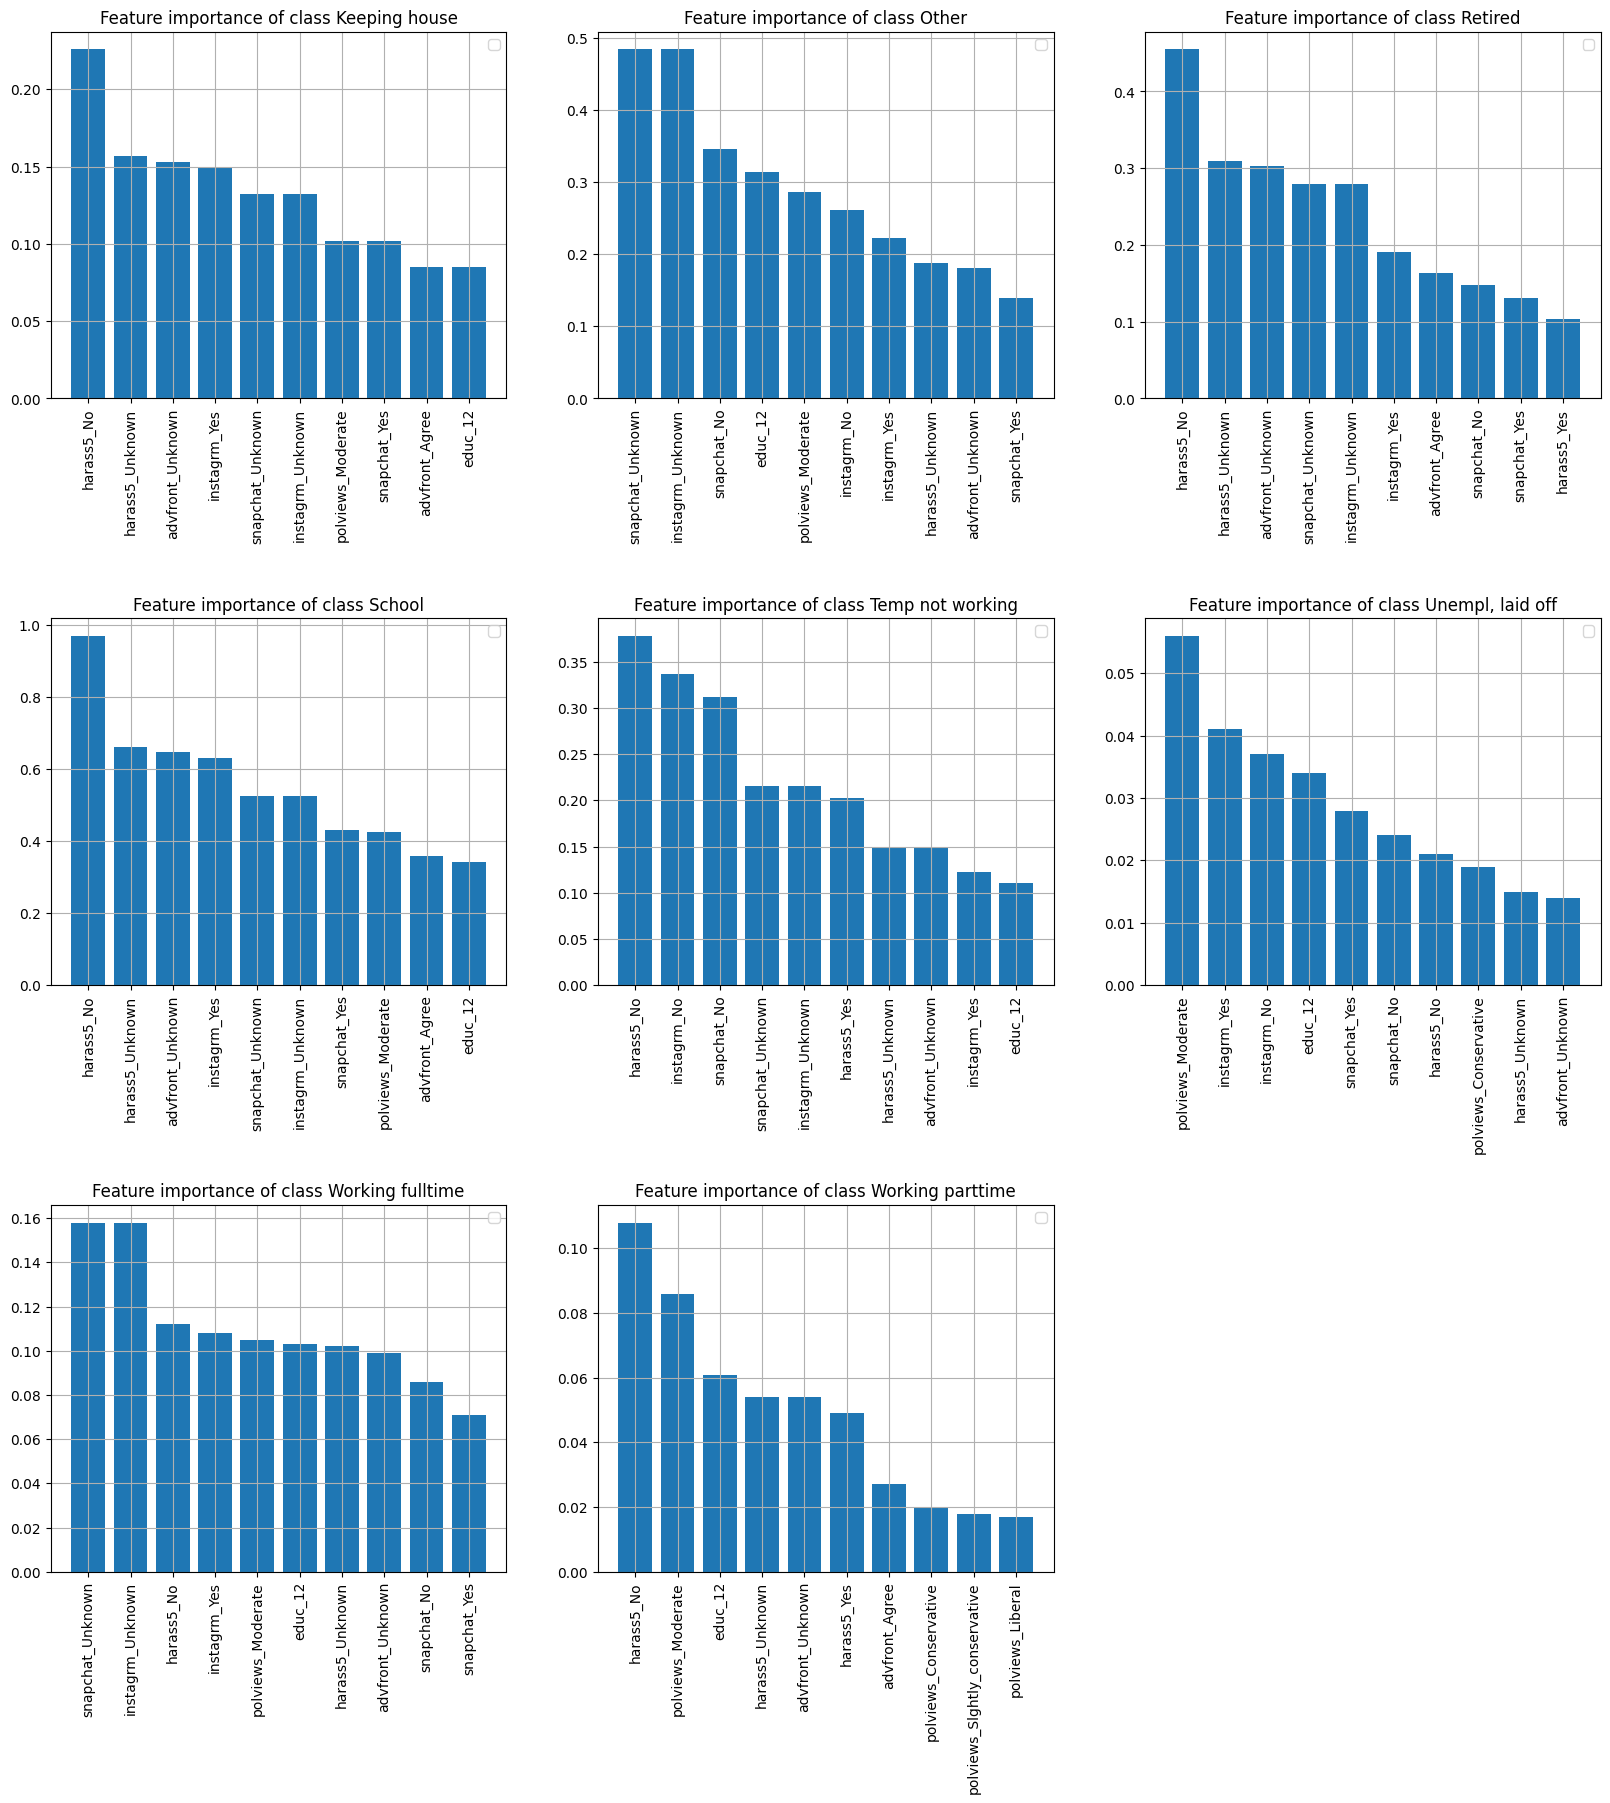

In [35]:
plot_bar_importance(importance)

### Barplot tương ứng với độ lớn bias tương ứng với từng lớp

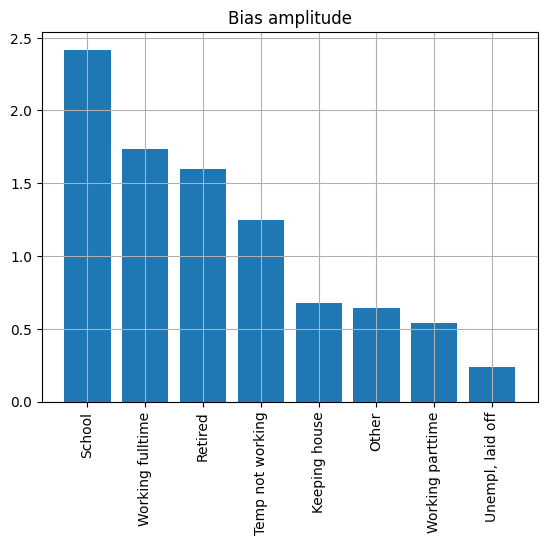

In [36]:
importance_intercept = dict(zip(np.vectorize(lambda x: index_to_pseudo_label[x])(np.argsort(np.abs(model.intercept_))[::-1]), np.round(model.intercept_[np.argsort(np.abs(model.intercept_))[::-1]], 3)))
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid()
plt.title("Bias amplitude")
plt.show()

## Sử dụng feature gốc

### Phân chia tập dữ liệu

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

### Huấn luyện mô hình Logistic

In [38]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='saga')

### Kết quả huấn luyện mô hình

In [39]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.12      0.04      0.06        55
           Other       0.00      0.00      0.00        23
         Retired       0.39      0.51      0.45       113
          School       0.00      0.00      0.00        13
Temp not working       0.00      0.00      0.00         8
Unempl, laid off       0.00      0.00      0.00        19
Working fulltime       0.51      0.82      0.63       198
Working parttime       0.00      0.00      0.00        55

        accuracy                           0.46       484
       macro avg       0.13      0.17      0.14       484
    weighted avg       0.32      0.46      0.37       484



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Ma trận nhầm lẫn cho tập test

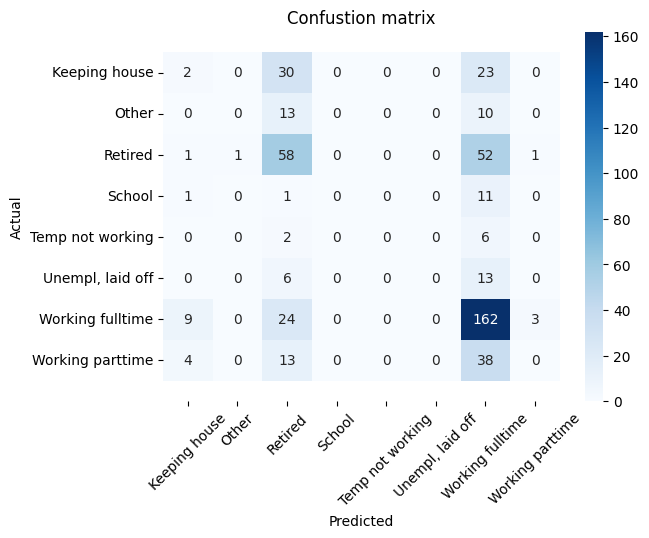

In [40]:
classes = model.classes_
plot_confusion_matrix(y_test, y_pred, classes=classes)

### weight tương ứng các đặc trưng ban đầu

In [41]:
original_weights = model.coef_

### Trọng số của các đặc trưng cao nhất tương ứng với từng nhãn giả

In [42]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1][:top_k_features]], 3)))
    
importance

{'Keeping house': {'polviews_Extremely_liberal': 0.894,
  'educ_15': -0.881,
  'educ_14': -0.876,
  'advfront_Disagree': -0.816,
  'educ_6': 0.795,
  'educ_9': 0.611,
  'advfront_Agree': 0.579,
  'polviews_Slightly_liberal': -0.571,
  'educ_0': 0.568,
  'educ_1': 0.508},
 'Other': {'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)': 1.384,
  'harass5_Yes': -0.88,
  'educ_7': 0.866,
  'educ_5': 0.765,
  'educ_12': 0.632,
  'educ_11': -0.571,
  'advfront_Strongly_agree': 0.57,
  'polviews_Unknown': -0.44,
  'snapchat_Unknown': 0.424,
  'instagrm_Unknown': 0.424},
 'Retired': {'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)': 1.254,
  'harass5_Yes': -1.047,
  'snapchat_Yes': -0.871,
  'instagrm_Yes': -0.807,
  'advfront_Dont_know': 0.706,
  'educ_7': -0.7,
  'educ_17': 0.667,
  'educ_15': -0.641,
  'snapchat_Unknown': 0.612,
  'instagrm_Unknown': 0.612},
 'School': {'snapchat_Yes': 1.055,
  'educ_14': 0.849,
  'snapchat_Unknown': -0.76,
  'instagrm_Unknown'

### Biểu đồ cột các weight của các đặc trưng tương ứng với từng lớp

f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
f:\Programming\PythonProjects\Master\Social_Sciences_Analysis\Final_Term\utils.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to 

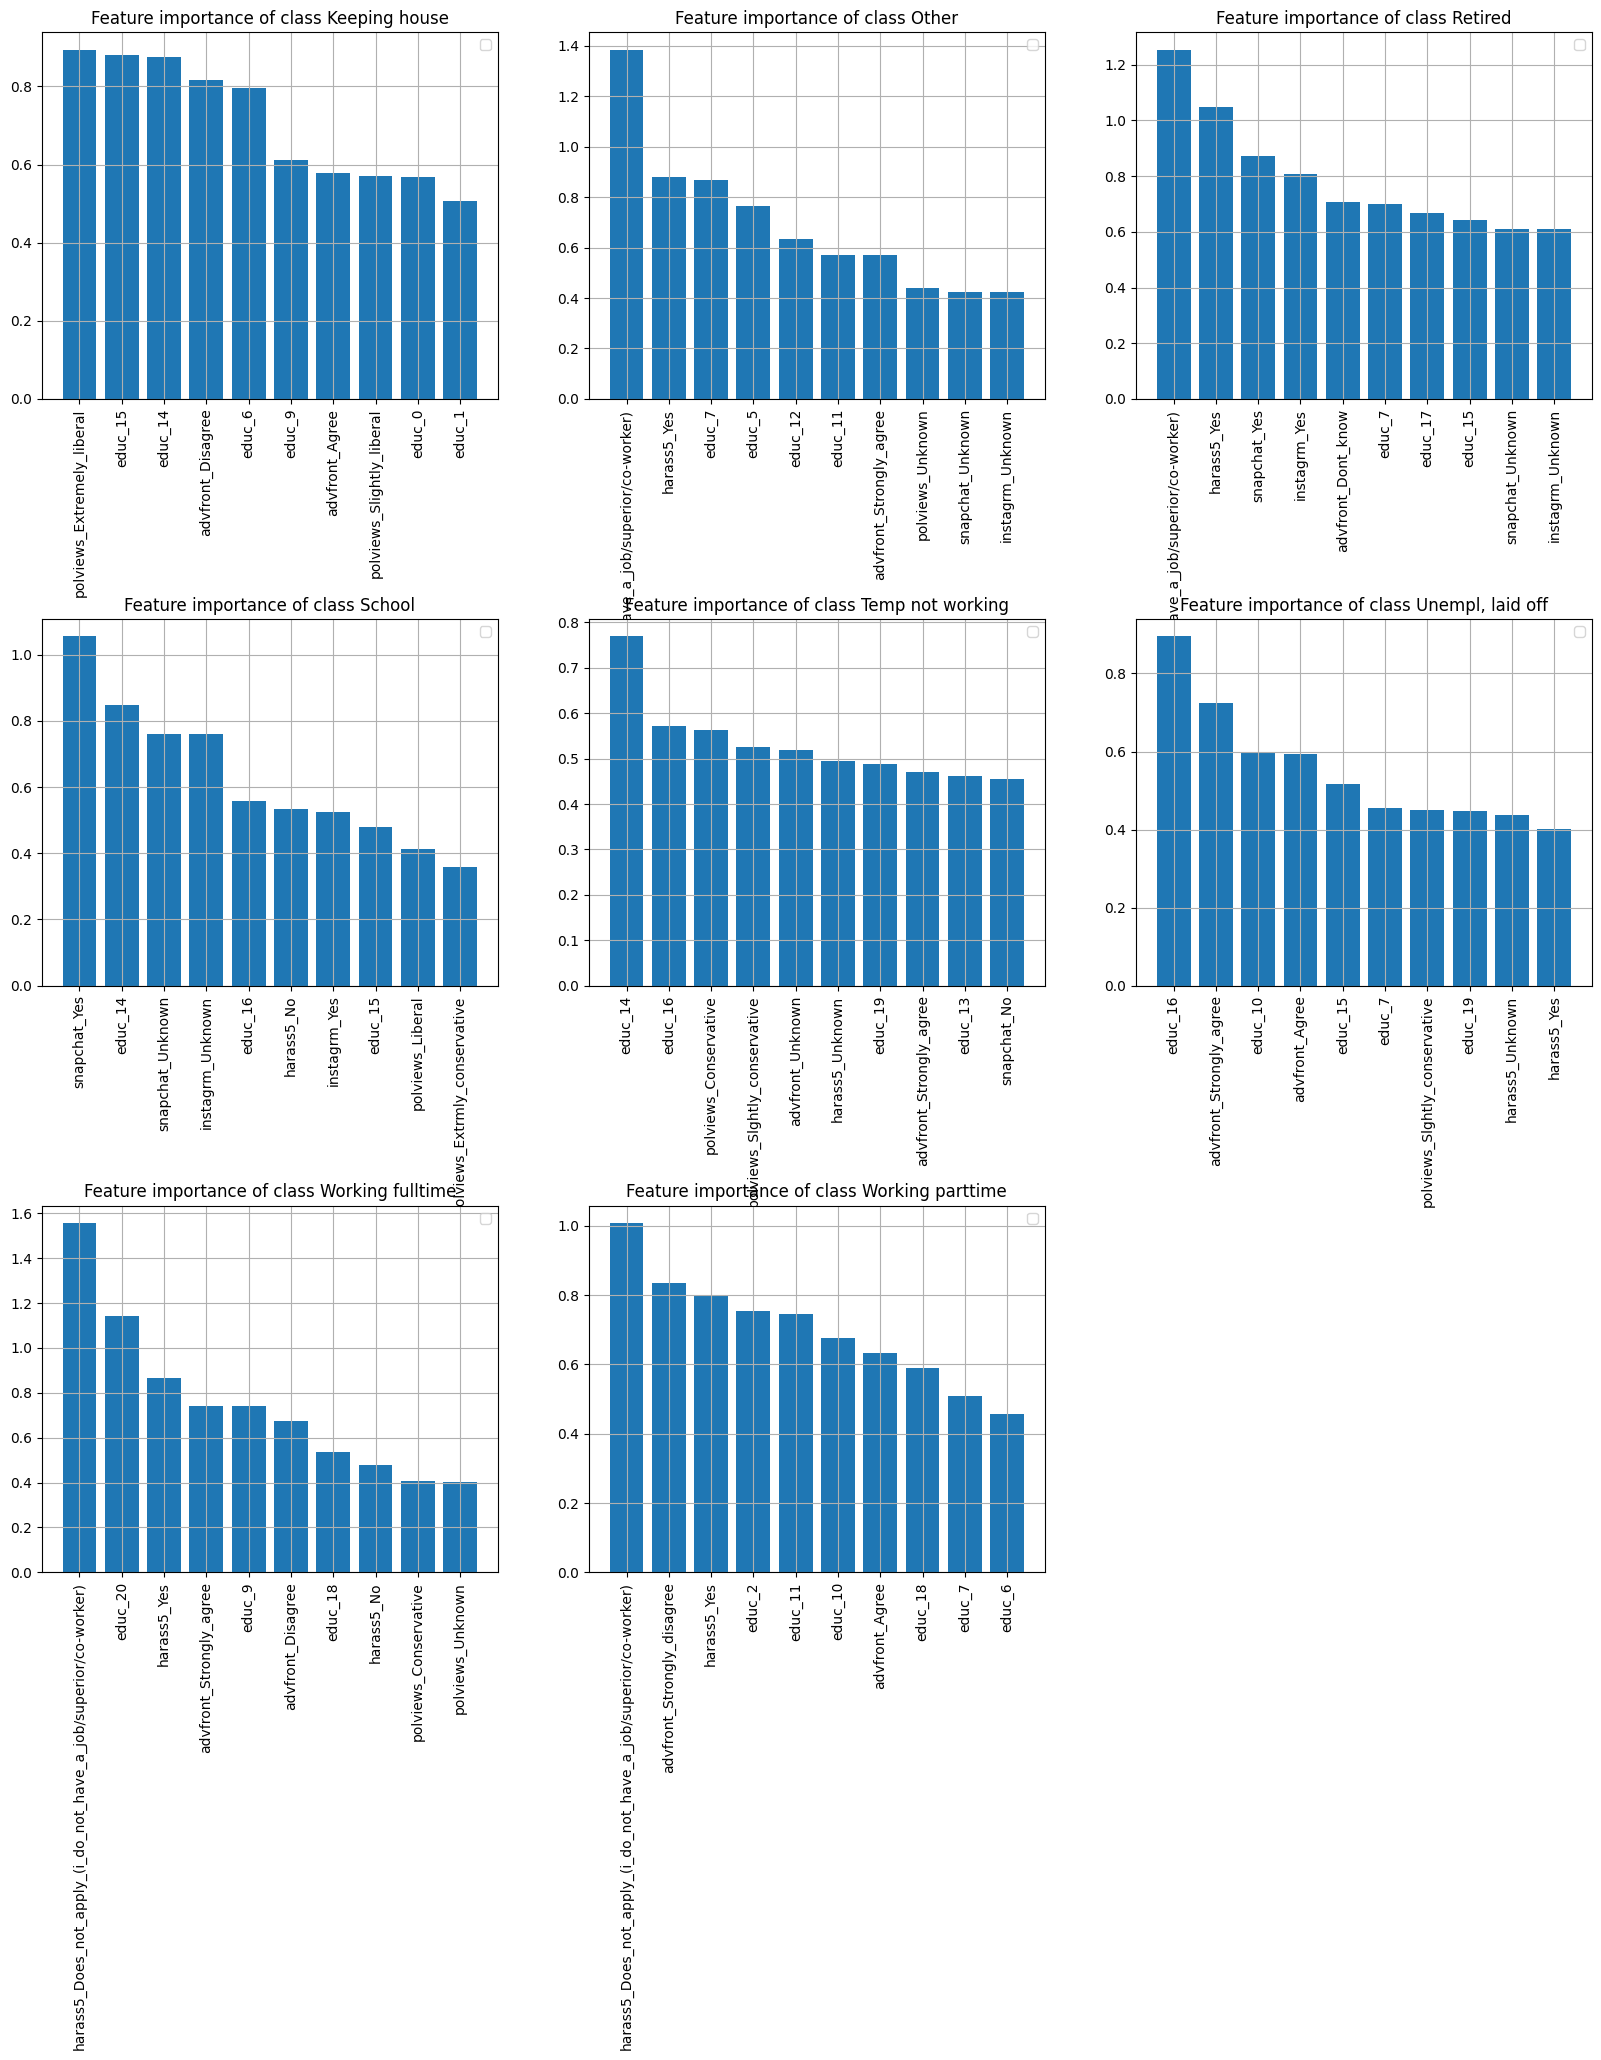

In [43]:
plot_bar_importance(importance)

### Barplot tương ứng với độ lớn bias tương ứng với từng lớp

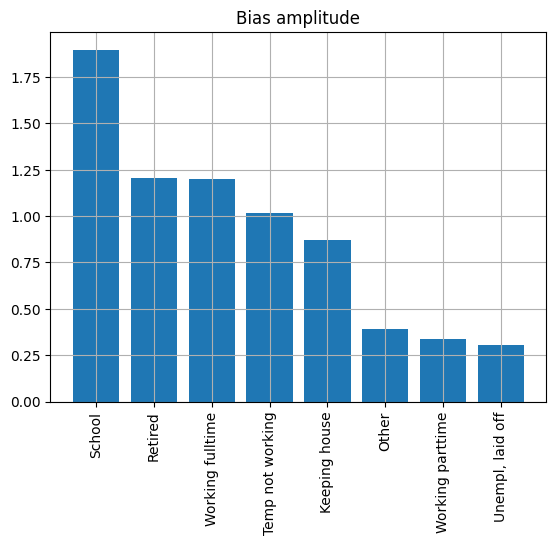

In [44]:
importance_intercept = dict(zip(np.vectorize(lambda x: index_to_pseudo_label[x])(np.argsort(np.abs(model.intercept_))[::-1]), np.round(model.intercept_[np.argsort(np.abs(model.intercept_))[::-1]], 3)))
plt.bar(importance_intercept.keys(), np.abs(list(importance_intercept.values())))
plt.xticks(rotation=90)
plt.grid()
plt.title("Bias amplitude")
plt.show()